# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

In [1]:
from platform import python_version

print(python_version())
import sys
sys.executable


3.8.6


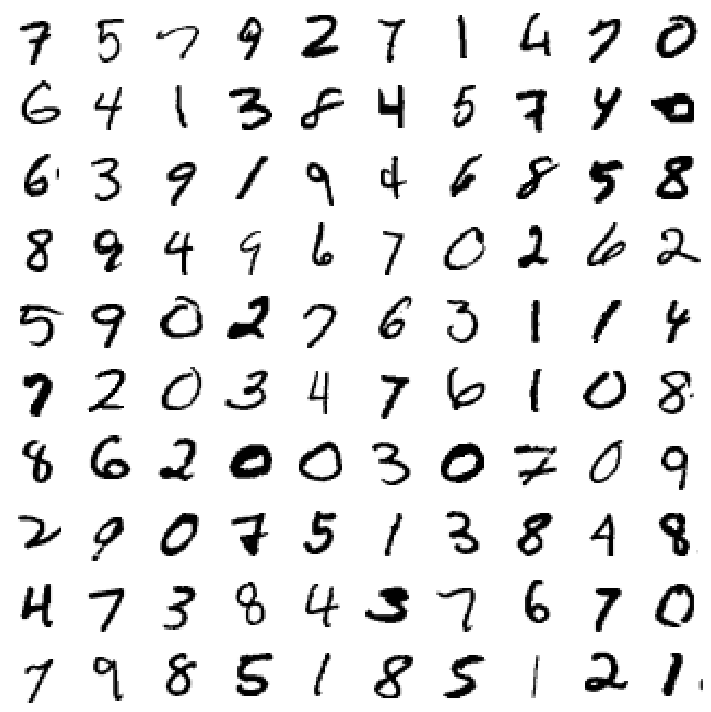

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Compile and train the network (note that this could take a while).

In [4]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
 61/469 [==>...........................] - ETA: 54s - loss: 0.7285 - accuracy: 0.7725

KeyboardInterrupt: 

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

In [5]:
print('start')

start


(20, 584, 565, 3)


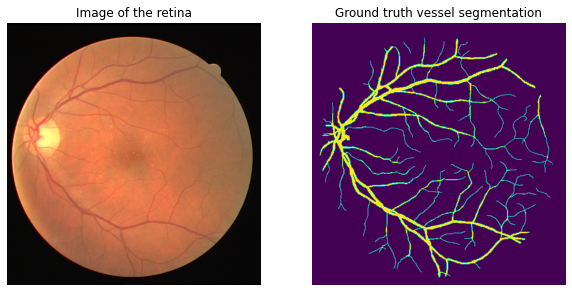

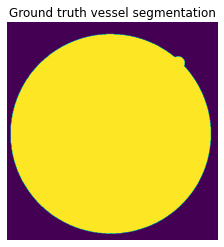

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [61]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import sys
sys.path.append('code/')

# import unet_utils
from unet_utils import load_data
# %run unet_utils
# location of the DRIVE dataset
data_folder = 'data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

plt.figure()
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(masks[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)
                 
# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


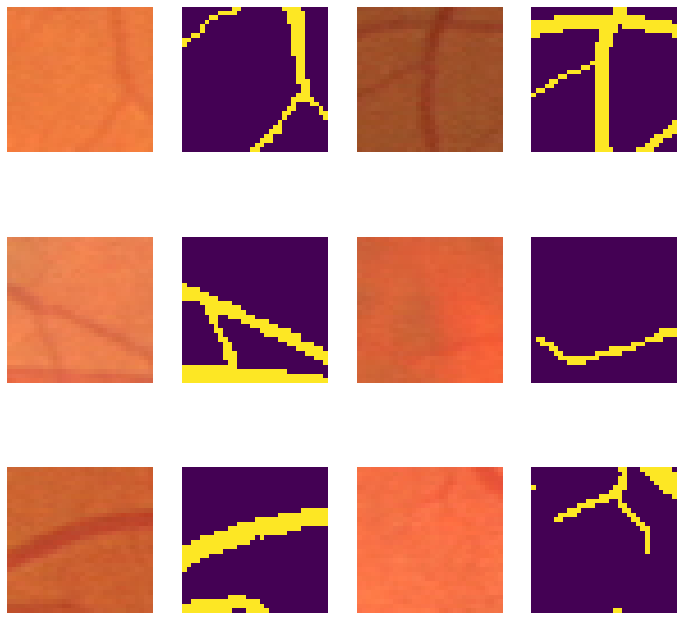

In [62]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [63]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [9]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)


# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/250
50/50 - 47s - loss: 0.5214 - accuracy: 0.8126 - val_loss: 1.1660 - val_accuracy: 0.1340
Epoch 2/250
50/50 - 46s - loss: 0.3008 - accuracy: 0.9524 - val_loss: 0.2936 - val_accuracy: 0.9211
Epoch 3/250
50/50 - 47s - loss: 0.2270 - accuracy: 0.9542 - val_loss: 18.0555 - val_accuracy: 0.1493
Epoch 4/250
50/50 - 46s - loss: 0.1759 - accuracy: 0.9579 - val_loss: 0.6403 - val_accuracy: 0.9174
Epoch 5/250
50/50 - 47s - loss: 0.1533 - accuracy: 0.9603 - val_loss: 0.5379 - val_accuracy: 0.9209
Epoch 6/250
50/50 - 47s - loss: 0.1366 - accuracy: 0.9598 - val_loss: 0.8189 - val_accuracy: 0.9216
Epoch 7/250
50/50 - 47s - loss: 0.1678 - accuracy: 0.9498 - val_loss: 0.5202 - val_accuracy: 0.8949
Epoch 8/250
50/50 - 46s - loss: 0.1340 - accuracy: 0.9585 - val_loss: 0.3703 - val_accuracy: 0.9061
Epoch 9/250
50/50 - 48s - loss: 0.1225 - accuracy: 0.9612 - val_loss: 0.4091 - val_accura

### Visualizing the segmentation results

In [5]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

NameError: name 'model' is not defined

In [180]:
test_predictions = model.predict(test_images, batch_size=4)

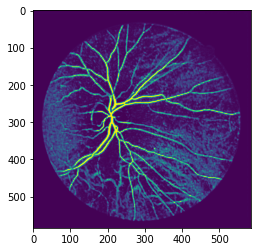

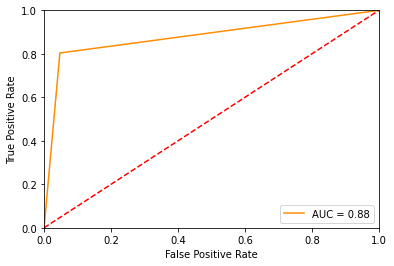

In [184]:
plt.figure()
plt.imshow(test_predictions[14,:,:,0])
plot_roc_curve(y_pred=test_predictions, y_true=test_segmentations,title = '')


# Exercises
## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

$\textbf{Answers:}$These parameters correspond to the number trainable parameters in the modellayer. The general expressions for these two different layers are: <br>

$\textbf{1: convolutional layer}$ number of parameters = filters x kernel size x input layer size + biases( number of filters)
in the MNIST example the parameters for the convolutional layer is given by: $32 * (3 * 3) * 1 + 32 = 320$ parameters <br>

$\textbf{2: fully-connected layer}$ number of parameters = output size * (input layer size + 1)
in the MNIST example the fully connected layer is calculated by: 
$128 * (9216 + 1) = 1179776 $ parameters

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 


## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>


Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.



AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

In [65]:
#only brightness
import random
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot


def brightness_augmentation(train_images = [], brightness_range = [0.5,1.5]):
    augmented_data = []
    imageNew = expand_dims(train_images[0], 0)
    imageDataGen = ImageDataGenerator(brightness_range=brightness_range)
    iterator = imageDataGen.flow(imageNew, batch_size=1)

    for k in range(len(train_images)):
        batch = iterator.next()
        image = np.array(batch[0].astype('uint8'))
        augmented_data.append(image/255)
    return np.array(augmented_data)

# train_images_bright = np.concatenate((train_images,brightness_augmentation(train_images = train_images)),axis=0)
# train_segmentations_bright = np.concatenate((train_segmentations,train_segmentations),axis=0)


train_images_bright = np.concatenate((X_train,brightness_augmentation(train_images = X_train)),axis=0)
train_segmentations_bright = np.concatenate((y_train,y_train),axis=0)



NameError: name 'X_train' is not defined

In [85]:
import numpy as np
import gryds
import copy 

def bspline_func(image_input=[],random_grid= []):
     # Define a B-spline transformation object
    bspline = gryds.BSplineTransformation(random_grid)

    # Define an interpolator object for the image:
    interpolator = gryds.Interpolator(image_input)

    # Transform the image using the B-spline transformation
    transformed_image = interpolator.transform(bspline)
    return transformed_image


def gryds_augmentation(input_images = [],input_segmentations = [],input_masks=[]):
    augmented_images = []
    augmented_segmentations = []
    augmented_masks = []

    for j in range(len(input_images)):
        bsplined_image = copy.deepcopy(input_images[1])
#         bsplined_segmentation = copy.deepcopy(input_segmentations[1,:,:,0])
#         bsplined_mask = copy.deepcopy(input_masks[1,:,:,0])

        # Define a random 3x3 B-spline grid for a 2D image:
        random_grid = np.random.rand(2, 3, 3)
        random_grid -= 0.5
        random_grid /= 5



        for i in range(3):
            transformed_image = bspline_func(bsplined_image[:,:,i],random_grid)
            bsplined_image[:,:,i] = transformed_image  
        bsplined_segmentation = bspline_func(input_segmentations[1,:,:,0],random_grid)
        bsplined_mask = bspline_func(input_masks[1,:,:,0],random_grid)

        
        augmented_images.append(bsplined_image)
        augmented_segmentations.append(bsplined_segmentation)
        augmented_masks.append(bsplined_mask)
    
    augmented_images = np.array(augmented_images)
    augmented_segmentations = np.array(augmented_segmentations)
    augmented_masks = np.array(augmented_masks)
    return augmented_images, new_segmentations[:,:,:,np.newaxis], new_masks[:,:,:,np.newaxis]

new_images,new_segmentations,new_masks = gryds_augmentation(train_images,train_segmentations,train_masks)


In [88]:
gryds_images = np.concatenate((train_images,new_images),axis=0)
gryds_segmentations = np.concatenate((train_segmentations,new_segmentations),axis=0)
gryds_masks = np.concatenate((train_masks,new_masks),axis=0)


In [7]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from unet_utils import extract_patches, preprocessing


def train_Unet_model(X_train_data = [],y_train_data = []):

    # work with 32x32 patches
    patch_size = (32, 32)

    # 200 patches per image
    patches_per_im = 200

    # visualize a couple of patches as a visual check
    patches, patches_segmentations = extract_patches(X_train_data, y_train_data, patch_size, patches_per_im=1, seed=7)

    # hyperparameters
    depth = 3
    channels = 32
    use_batchnorm = True
    batch_size = 64
    epochs = 250
    patches_per_im = 200
    steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

   
    # 200 patches per image
    

    # initialize model
    unet_model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

    # print a summary of the model
    # model.summary(line_length=120)

    # compile the model
    unet_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # stop the training if the validation loss does not increase for 15 consecutive epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # train the model with the data generator, and save the training history
    history = unet_model.fit_generator(datagenerator(X_train_data, y_train_data, patch_size, patches_per_im, batch_size),
                                  validation_data=(val_images, val_segmentations),
                                  steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                                  callbacks=[early_stopping])
    return unet_model




(2, 584, 565, 1)


(1, 584, 565, 1)

In [210]:
# model_original = train_Unet_model(train_images,train_segmentations)

model_original = train_Unet_model(X_train_data = X_train,y_train_data = y_train)

Epoch 1/250
50/50 - 47s - loss: 0.5463 - accuracy: 0.7939 - val_loss: 1.2803 - val_accuracy: 0.1238
Epoch 2/250
50/50 - 44s - loss: 0.3207 - accuracy: 0.9470 - val_loss: 0.3134 - val_accuracy: 0.9211
Epoch 3/250
50/50 - 47s - loss: 0.2367 - accuracy: 0.9536 - val_loss: 0.2967 - val_accuracy: 0.9211
Epoch 4/250
50/50 - 46s - loss: 0.1889 - accuracy: 0.9558 - val_loss: 0.2806 - val_accuracy: 0.9211
Epoch 5/250
50/50 - 47s - loss: 0.1626 - accuracy: 0.9574 - val_loss: 0.3079 - val_accuracy: 0.9211
Epoch 6/250
50/50 - 46s - loss: 0.1381 - accuracy: 0.9599 - val_loss: 0.3679 - val_accuracy: 0.9198
Epoch 7/250
50/50 - 46s - loss: 0.1241 - accuracy: 0.9616 - val_loss: 0.2972 - val_accuracy: 0.9190
Epoch 8/250
50/50 - 46s - loss: 0.1211 - accuracy: 0.9615 - val_loss: 0.2787 - val_accuracy: 0.9259
Epoch 9/250
50/50 - 48s - loss: 0.1121 - accuracy: 0.9635 - val_loss: 0.2311 - val_accuracy: 0.9330
Epoch 10/250
50/50 - 47s - loss: 0.1090 - accuracy: 0.9637 - val_loss: 0.2386 - val_accuracy: 0.9360

In [212]:
model_bright = train_Unet_model(X_train_data = train_images_bright,y_train_data = train_segmentations_bright)

Epoch 1/250
50/50 - 46s - loss: 0.4953 - accuracy: 0.8392 - val_loss: 0.3786 - val_accuracy: 0.9211
Epoch 2/250
50/50 - 48s - loss: 0.2655 - accuracy: 0.9543 - val_loss: 0.2764 - val_accuracy: 0.9211
Epoch 3/250
50/50 - 48s - loss: 0.1980 - accuracy: 0.9592 - val_loss: 0.2703 - val_accuracy: 0.9211
Epoch 4/250
50/50 - 49s - loss: 0.1573 - accuracy: 0.9605 - val_loss: 0.2891 - val_accuracy: 0.9211
Epoch 5/250
50/50 - 49s - loss: 0.1325 - accuracy: 0.9641 - val_loss: 0.3086 - val_accuracy: 0.9212
Epoch 6/250
50/50 - 50s - loss: 0.1155 - accuracy: 0.9647 - val_loss: 0.3646 - val_accuracy: 0.9213
Epoch 7/250
50/50 - 49s - loss: 0.1072 - accuracy: 0.9652 - val_loss: 0.3930 - val_accuracy: 0.9208
Epoch 8/250
50/50 - 49s - loss: 0.1014 - accuracy: 0.9665 - val_loss: 0.3317 - val_accuracy: 0.9234
Epoch 9/250
50/50 - 49s - loss: 0.0996 - accuracy: 0.9656 - val_loss: 0.3308 - val_accuracy: 0.9256
Epoch 10/250
50/50 - 48s - loss: 0.0921 - accuracy: 0.9680 - val_loss: 0.3179 - val_accuracy: 0.9272

In [8]:
# test_prediction_original = model_original.predict(X_test[:,:,:,:], batch_size=4)
# test_prediction_bright = model_bright.predict(X_test[:,:,:,:], batch_size=4)
test_prediction_original = model_original.predict(test_images, batch_size=4)
test_prediction_bright = model_bright.predict(test_images, batch_size=4)


NameError: name 'model_original' is not defined

In [14]:
#roc curve of original model

from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_pred=[], y_true=[],title = ''):
    fpr,tpr,treshold = roc_curve(np.round(y_pred.reshape(np.size(y_pred))), y_true.reshape(np.size(y_true)))
    print(fpr,tpr)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    plt.plot(fpr,tpr,color = 'darkorange',label = 'AUC = %0.2f' %roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(title)
    plt.show()
    
plot_roc_curve(y_pred = test_prediction_original,y_true = test_segmentations,title='Original model')
plot_roc_curve(y_pred = test_prediction_bright,y_true =test_segmentations,title= 'Bright data augmentation model')


NameError: name 'test_prediction_original' is not defined

In [68]:
train_images_bright2.shape

(32, 584, 565, 3)

In [66]:
train_images_bright2 = np.concatenate((train_images,brightness_augmentation(train_images = train_images)),axis=0)
train_segmentations_bright2 = np.concatenate((train_segmentations,train_segmentations),axis=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/250
50/50 - 66s - loss: 0.5598 - accuracy: 0.7871 - val_loss: 0.6809 - val_accuracy: 0.5885
Epoch 2/250
50/50 - 200s - loss: 0.5169 - accuracy: 0.8716 - val_loss: 0.7919 - val_accuracy: 0.3852
Epoch 3/250
50/50 - 45s - loss: 0.3642 - accuracy: 0.9129 - val_loss: 0.4612 - val_accuracy: 0.7459
Epoch 4/250
50/50 - 57s - loss: 0.3616 - accuracy: 0.8952 - val_loss: 0.3308 - val_accuracy: 0.9211
Epoch 5/250
50/50 - 62s - loss: 0.2410 - accuracy: 0.9274 - val_loss: 0.3118 - val_accuracy: 0.9120
Epoch 6/250
50/50 - 62s - loss: 0.3334 - accuracy: 0.8898 - val_loss: 0.3166 - val_accuracy: 0.9211
Epoch 7/250
50/50 - 62s - loss: 0.2009 - accuracy: 0.9357 - val_loss: 0.2568 - val_accuracy: 0.9213
Epoch 8/250
50/50 - 61s - loss: 0.3053 - accuracy: 0.9006 - val_loss: 0.2429 - val_accuracy: 0.9211
Epoch 9/250
50/50 - 61s - loss: 0.2108 - accuracy: 0.9298 - val_loss: 0.2304 - val_accuracy: 0.9214
Epoch 10/250
50/50 - 62

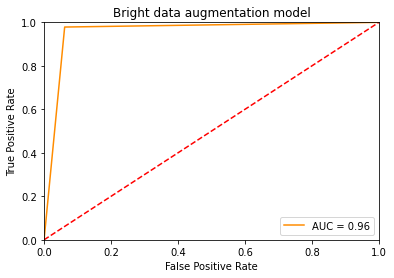

In [12]:
model_bright2 = train_Unet_model(X_train_data = train_images_bright2,y_train_data = train_segmentations_bright2)
test_prediction_bright2 = model_bright2.predict(test_images, batch_size=4)
plot_roc_curve(y_pred = test_prediction_bright2,y_true =test_segmentations,title= 'Bright data augmentation model')


[0. 0. 0. ... 0. 0. 0.]
6821120
[0.         0.06149982 1.        ] [0.        0.9784828 1.       ]


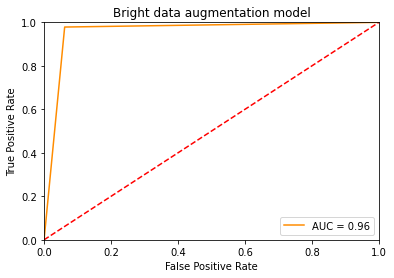

In [17]:


plot_roc_curve(y_pred = test_prediction_bright2,y_true =test_segmentations,title= 'Bright data augmentation model')
plt.figure()
plt.imshow()

In [13]:
model_original2 = train_Unet_model(X_train_data = train_images,y_train_data = train_segmentations)
test_prediction_original2 = model_original2.predict(test_images, batch_size=4)
plot_roc_curve(y_pred = test_prediction_original2,y_true = test_segmentations,title='Original model')


Epoch 1/250
50/50 - 83s - loss: 0.5460 - accuracy: 0.7992 - val_loss: 0.4308 - val_accuracy: 0.9211
Epoch 2/250
50/50 - 89s - loss: 0.3276 - accuracy: 0.9348 - val_loss: 0.2769 - val_accuracy: 0.9211
Epoch 3/250
50/50 - 79s - loss: 0.2426 - accuracy: 0.9473 - val_loss: 0.2754 - val_accuracy: 0.9211
Epoch 4/250
50/50 - 87s - loss: 0.2004 - accuracy: 0.9492 - val_loss: 0.2576 - val_accuracy: 0.9211
Epoch 5/250
50/50 - 97s - loss: 0.1791 - accuracy: 0.9471 - val_loss: 0.3050 - val_accuracy: 0.9212
Epoch 6/250
50/50 - 83s - loss: 0.1569 - accuracy: 0.9541 - val_loss: 0.2289 - val_accuracy: 0.9256
Epoch 7/250
50/50 - 87s - loss: 0.1397 - accuracy: 0.9559 - val_loss: 0.2238 - val_accuracy: 0.9281
Epoch 8/250
50/50 - 85s - loss: 0.1431 - accuracy: 0.9524 - val_loss: 0.2244 - val_accuracy: 0.9345
Epoch 9/250
50/50 - 86s - loss: 0.1256 - accuracy: 0.9576 - val_loss: 0.1515 - val_accuracy: 0.9478
Epoch 10/250
50/50 - 90s - loss: 0.1199 - accuracy: 0.9593 - val_loss: 0.1413 - val_accuracy: 0.9516

KeyboardInterrupt: 